In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json, pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# dataset path



In [ ]:
def cleaning_documents(labels):
    if labels==1.0:
        newlab='real'
    else:
        newlab='fake'
    return newlab

In [ ]:
data['newlabel1'] = data['label'].apply(cleaning_documents)

In [ ]:
data

,Unnamed: 0,content,label,newlabel,newlabel1
0,0,ক্রিকেট বিশ্বের নতুন চমকের নাম আফগানিস্তান। কয়...,1.0,fake,real
1,1,এশিয়া কাপের ষষ্ঠ ম্যাচে বাংলাদেশ দলের বিপক্ষে ...,0.0,fake,fake
2,2,রাজধানীতে মাদক বিরোধী বিশেষ অভিযান পরিচালনা কর...,1.0,fake,real
3,3,সনাতন ধর্মাবলম্বীদের সবচেয়ে বড় ধর্মীয় উৎসব দুর...,1.0,fake,real
4,4,ভারত থেকে পাইপ লাইনের মাধ্যমে সরাসরি দেশে জ্বা...,0.0,fake,fake
...,...,...,...,...,...
7197,7197,কুমিল্লার বুড়িচং উপজেলার এবদারপুর গ্রামে সাবেক...,1.0,fake,real
7198,7198,নানা মাঙ্গলিক আয়োজনের মধ্যে দিয়ে বান্দরবানে পা...,1.0,fake,real
7199,7199,নারায়ণগঞ্জের সিদ্ধিরগঞ্জে শীর্ষ মাদক ব্যবসায়ী ...,1.0,fake,real
7200,7200,২০ বছরের পুরনো নীতিমালা দিয়েই চলছে দেশের টেলিয...,1.0,fake,real


In [ ]:
# Read the data
data = pd.read_csv('/content/drive/MyDrive/fakerealnews.csv',encoding='utf-8')
data=data.dropna()
print(f'Total number of Documents: {len(data)}')

Total number of Documents: 7202


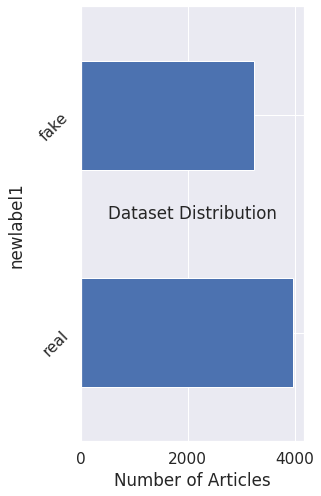

In [ ]:


# Plot the Class distribution
sns.set(font_scale=1.4)
data['newlabel1'].value_counts().plot(kind='barh', figsize=(4, 8))
plt.xlabel("Number of Articles", labelpad=5)
plt.ylabel("newlabel1", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=.5);

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Cleaning Data [Remove unncessary symbols]
def cleaning_documents(articles):
      '''
      This function will clean the news articles by removing punctuation marks and stopwords.

      Args:
      articles: a news text(str)

      returns:
      news: clean text (str)
      '''
      news = articles.replace('\n',' ')
      news = re.sub('[^\u0980-\u09FF]',' ',str(news)) #removing unnecessary punctuation
      # stopwords removal
      stp = open('/content/drive/MyDrive/bangla_stopwords.pkl','r', encoding= 'unicode_escape').read().split()
      result = news.split()
      news = [word.strip() for word in result if word not in stp ]
      news =" ".join(news)
      return news

In [ ]:
data['cleaned'] = data['content'].apply(cleaning_documents)

In [ ]:
# Calculate the Length of each Document
data['Length'] = data.cleaned.apply(lambda x:len(x.split()))

# Remove the Documents with least words

dataset = data.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Documents".format(len(data)-len(dataset)),
      "\nTotal Remaining Documents:",len(dataset))

After Cleaning: 
Removed 0 Small Documents 
Total Remaining Documents: 7202


In [ ]:
dataset.to_csv('cleaned_news1sentiment.csv')

In [ ]:
dataset = pd.read_csv('/content/cleaned_news1sentiment.csv')
dataset=dataset.dropna()
dataset

,Unnamed: 0,Unnamed: 0.1,content,label,newlabel,newlabel1,cleaned,Length
0,0,0,ক্রিকেট বিশ্বের নতুন চমকের নাম আফগানিস্তান। কয়...,1.0,fake,real,ক্রিকেট বিশ্বের নতুন চমকের নাম আফগানিস্তান কয়ে...,118
1,1,1,এশিয়া কাপের ষষ্ঠ ম্যাচে বাংলাদেশ দলের বিপক্ষে ...,0.0,fake,fake,এশিয়া কাপের ষষ্ঠ ম্যাচে বাংলাদেশ দলের বিপক্ষে ...,196
2,2,2,রাজধানীতে মাদক বিরোধী বিশেষ অভিযান পরিচালনা কর...,1.0,fake,real,রাজধানীতে মাদক বিরোধী বিশেষ অভিযান পরিচালনা কর...,105
3,3,3,সনাতন ধর্মাবলম্বীদের সবচেয়ে বড় ধর্মীয় উৎসব দুর...,1.0,fake,real,সনাতন ধর্মাবলম্বীদের সবচেয়ে বড় ধর্মীয় উৎসব দুর...,107
4,4,4,ভারত থেকে পাইপ লাইনের মাধ্যমে সরাসরি দেশে জ্বা...,0.0,fake,fake,ভারত থেকে পাইপ লাইনের মাধ্যমে সরাসরি দেশে জ্বা...,243
...,...,...,...,...,...,...,...,...
7197,7197,7197,কুমিল্লার বুড়িচং উপজেলার এবদারপুর গ্রামে সাবেক...,1.0,fake,real,কুমিল্লার বুড়িচং উপজেলার এবদারপুর গ্রামে সাবেক...,181
7198,7198,7198,নানা মাঙ্গলিক আয়োজনের মধ্যে দিয়ে বান্দরবানে পা...,1.0,fake,real,নানা মাঙ্গলিক আয়োজনের মধ্যে দিয়ে বান্দরবানে পা...,89
7199,7199,7199,নারায়ণগঞ্জের সিদ্ধিরগঞ্জে শীর্ষ মাদক ব্যবসায়ী ...,1.0,fake,real,নারায়ণগঞ্জের সিদ্ধিরগঞ্জে শীর্ষ মাদক ব্যবসায়ী ...,259
7200,7200,7200,২০ বছরের পুরনো নীতিমালা দিয়েই চলছে দেশের টেলিয...,1.0,fake,real,২০ বছরের পুরনো নীতিমালা দিয়েই চলছে দেশের টেলিয...,156


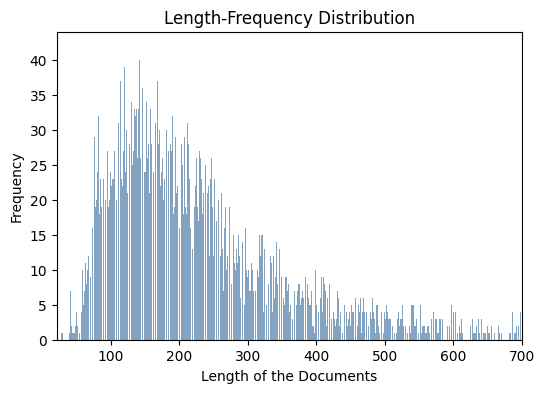

Maximum Length of a Document: 3788
Minimum Length of a Document: 0
Average Length of a Document: 261.0


In [ ]:
import matplotlib
matplotlib.rc_file_defaults()
frequency = dict()
for i in dataset.Length:
    frequency[i] = frequency.get(i, 0)+1

plt.figure(figsize = (6,4))
plt.bar(frequency.keys(), frequency.values(), color=(0.2, 0.4, 0.6, 0.6))
plt.xlim(21, 700)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Documents')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
#plt.savefig(path+'len_dist.png',dpi = 1000,bbox_inches ='tight')
plt.show()
print(f"Maximum Length of a Document: {max(dataset.Length)}")
print(f"Minimum Length of a Document: {min(dataset.Length)}")
print(f"Average Length of a Document: {round(np.mean(dataset.Length),0)}")


In [ ]:
def data_summary(dataset):
  '''
  This function will print the summary of the dataset

  Args:
  dataset: cleaned texts

  returns:
  documents: Number of document per class
  words: Number of words per class
  u_words: Number of unique words per class
  class_label: name of the categories
  '''
  documents = []
  words = []
  u_words = []
  #total_u_word = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
  # find class names
  class_label = [k for k,v in dataset.newlabel1.value_counts().to_dict().items()]
  for label in class_label:
    word_list = [word.strip().lower() for t in list(dataset[dataset.newlabel1==label].cleaned) for word in t.strip().split()]
    counts = dict()
    for word in word_list:
      counts[word] = counts.get(word, 0)+1
    # sort the dictionary of word list
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Documents per class
    documents.append(len(list(dataset[dataset.newlabel1==label].cleaned)))
    # Total Word per class
    words.append(len(word_list))
    # Unique words per class
    u_words.append(len(np.unique(word_list)))

    print("\nClass Name : ",label)
    print("Number of Documents:{}".format(len(list(dataset[dataset.newlabel1==label].cleaned))))
    print("Number of Words:{}".format(len(word_list)))
    print("Number of Unique Words:{}".format(len(np.unique(word_list))))
    print("Most Frequent Words:\n")
    for k,v in ordered[:10]:
      print("{}\t{}".format(k,v))
  return documents,words,u_words,class_label

# pass the whole dataset into the function

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  real
Number of Documents:3964
Number of Words:1011281
Number of Unique Words:57274
Most Frequent Words:

ও	12140
করে	8768
এ	7085
থেকে	6587
না	5957
করা	5951
বলেন	5544
হয়েছে	5256
হয়	5246
তিনি	5003

Class Name :  fake
Number of Documents:3236
Number of Words:868491
Number of Unique Words:56168
Most Frequent Words:

ও	9736
করে	7171
এ	5581
থেকে	5526
না	5203
করা	4634
এই	4548
তিনি	4506
বলেন	4314
হয়	4171


In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data_matrix

,Total Documents,Total Words,Unique Words,Class Names
0,3964,1011281,57274,real
1,3236,868491,56168,fake


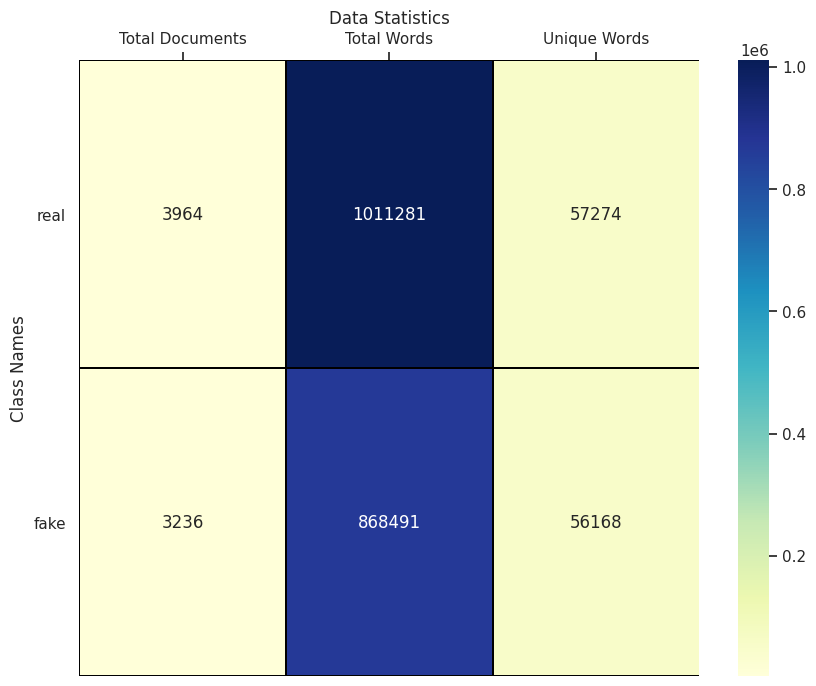

In [ ]:
sns.set()
plt.figure(figsize =(10, 8))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)
# labels, title and ticks
ax.set_ylabel('Class Names')
ax.set_title('Data Statistics')
y_label = ["Total Documents", "Total Words", "Unique Words"]
ax.xaxis.set_ticklabels(y_label); ax.yaxis.set_ticklabels(class_names, rotation=360);
ax.xaxis.tick_top()

In [ ]:
                   #===========================================================
                   ################# Label Encoding Function ##################
                   #===========================================================
def label_encoding(dataset,bool):
  '''
  This function will convert categorical class names into a numeric label

  Args:
  dataset: A dataset
  bool : a boolean (True or False)

  returns:
  labels: encoded labels
  '''
  le = LabelEncoder()
  le.fit(dataset.newlabel1)
  encoded_labels = le.transform(dataset.newlabel1)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print(color.BOLD+"\n\t\t\t===== Label Encoding ====="+color.END,"\nClass Names:-->",le.classes_)
  return labels

                   #===========================================================
                   ################# Dataset Splitting Function ###############
                   #===========================================================

def dataset_split(news,category):
  '''
  This function will split the dataset into Train-Test-Validation set

  Args:
  news: encoded texts
  category: class names

  returns:
  X_train: Encoded Training News
  X_valid: Encoded Validation News
  X_test:  Encoded Test news
  y_train: Encoded Training labels
  y_valid: Encoded Validation labels
  y_test:  Encoded Test labels
  '''

  X,X_test,y,y_test = train_test_split(news,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
  X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
  print(color.BOLD+"Feature Size :======>"+color.END,X_train.shape[1])
  print(color.BOLD+"\nDataset Distribution:\n"+color.END)
  print("\tSet Name","\t\tSize")
  print("\t========\t\t======")

  print("\tFull\t\t\t",news.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0],
        "\n\tValidation\t\t",X_valid.shape[0])

  return X_train,X_valid,X_test,y_train,y_valid,y_test


In [ ]:
def encoded_texts(dataset,padding_length,max_words):

  '''
  This function will encoded the text into a sequence of numbers

  Args:
  dataset: a dataset
  padding_length: maximum length of a encoded texte
  max_words : Number of words

  returns:
  corpus: Number of encoded texts
  labels: encoded labels
  '''

  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-',
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)



 # Fit the tokenizer
  tokenizer.fit_on_texts(dataset.cleaned)
  #============================== Tokenizer Info =================================
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  def tokenizer_info(mylist,bool):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
    for w,c in ordered[:10]:
      print(w,"\t",c)
  #=============================== Print all the information =========================
  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)
  print("Words --> Counts:")
  tokenizer_info(word_counts,bool =True )
  print("\nWords --> Documents:")
  tokenizer_info(word_docs,bool =True )
  print("\nWords --> Index:")
  tokenizer_info(word_index,bool =True )
  print("\nTotal Documents -->",document_count)

  #=========================== Convert string into list of integer indices =================
  sequences = tokenizer.texts_to_sequences(dataset.cleaned)
  word_index = tokenizer.word_index
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))
  print(dataset.cleaned[10],"\n",sequences[10])

  #==================================== Pad Sequences ==============================
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",dataset.cleaned[10],"\n",corpus[10])

  #=================================     Label Encoding ================================
  labels = label_encoding(dataset,True)

   # save the tokenizer into a pickle file
  with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return corpus,labels

#call the function
num_words = 5000
corpus,labels = encoded_texts(dataset,
                                300,num_words)
print("\nShape of Encoded Corpus =====>",corpus.shape)

			====== Tokenizer Info ======
Words --> Counts:
ও 	 21876
করে 	 15939
এ 	 12666
থেকে 	 12113
না 	 11160
করা 	 10585
বলেন 	 9858
তিনি 	 9509
এই 	 9506
হয় 	 9417

Words --> Documents:
ও 	 5711
করে 	 5129
এ 	 5041
থেকে 	 4778
করা 	 4348
হয়েছে 	 4155
হয় 	 4141
তিনি 	 3656
এই 	 3521
না 	 3521

Words --> Index:
কাদায় 	 79851
উড়না 	 79850
কান্দিস 	 79849
নিমু 	 79848
একলগে 	 79847
বোলায় 	 79846
তৃষ্ণায় 	 79845
ফুলগুলোতে 	 79844
বোলালো 	 79843
গাছটা 	 79842

Total Documents --> 7200

			====== Encoded Sequences ====== 
Found 79851 unique tokens
মালয়েশিয়ায় রাজধানী কুয়ালালামপুরের আশপাশের এলাকায় এলকোহল মিশ্রিত পানীয় পান করে বাংলাদেশী সহ ২১ জন প্রাণ হারিয়েছেন এ ঘটনায় গুরুতর অসুস্থ হয়েছেন আরো ৩৬ জন নিহতদের মধ্যে রয়েছেন বাংলাদেশী নেপালি ভারতীয় মালয়েশিয়ান মিয়ানমারের নাগরিক তবে এর মধ্যে কতজন বাংলাদেশী রয়েছেন তা সুস্পষ্টভাবে জানা যায় নি সেখানকার কর্তৃপক্ষ বলেছে বুধবার ১৯ সেপ্টেম্বর রাজধানীর আশপাশে হুইস্কি ও বিয়ার পান করার পর এসব মৃত্যুর ঘটনা ঘটে এ ঘটনায় পুলিশ গ্রেপ্তার অভিযান চালিয়েছে বলা হয়েছে প্রথম

In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(corpus,labels)

Feature Size :======> 300

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 7200 
	Training		 5184 
	Test			 720 
	Validation		 1296


In [ ]:

embedding_dimension = 128
input_length = 300
vocab_size = 5000
num_classes = 14
batch_size = 64
num_epochs = 10

accuracy_threshold = 0.97


class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = "Model1.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint]

                            ###############################     CNN network architecture ################
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dimension, input_length = input_length),
tf.keras.layers.Conv1D(128, 5, activation= 'relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Dense(28, activation='relu'),
tf.keras.layers.Dense(14, activation='relu'),
keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation='softmax')])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(X_train,
    y_train,
    epochs=num_epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid),
    verbose =1)
    #callbacks = callback_list)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 59, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 59, 128)           98816     
_________________________________________________________________
dense (Dense)                (None, 59, 28)            3612      
_________________________________________________________________
dense_1 (Dense)              (None, 59, 14)            4

In [ ]:
# save the model
tf.keras.models.save_model(model, 'shagoto1sentiment.h5', save_format='h5')
#model.save('Document_Categorization.h5')

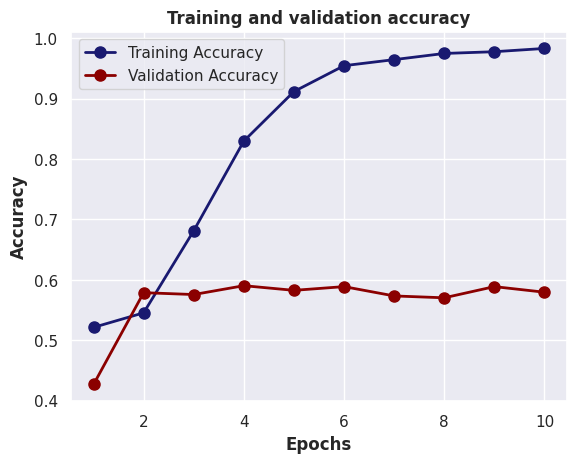

In [ ]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')
                  #=========================================================
                  ############### Epochs vs Validation Accuracy Plot ##########
                  #==========================================================

plt.plot(epochs, acc, color='midnightblue', linewidth = 2,
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2,
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training Accuracy','Validation Accuracy'])

In [ ]:
class_names = ['fake','real']
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0':'fake', '1': 'real'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report



,precision,recall,f1-score,support
fake,58.20,52.46,55.18,345.000000
real,59.90,65.33,62.50,375.000000
accuracy,59.17,59.17,59.17,0.591667
macro avg,59.05,58.90,58.84,720.000000
weighted avg,59.09,59.17,58.99,720.000000


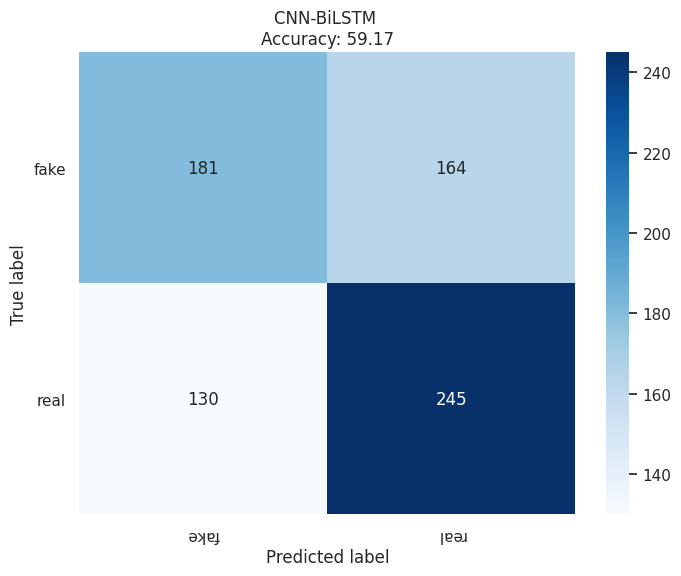

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)

class_names =  ['fake','real']
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names,
                     columns = class_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Blues", fmt='g')
plt.title('CNN-BiLSTM \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 180)
plt.yticks(rotation = 360)
plt.show()

In [ ]:
sample_news = input()
cleaned_news = cleaning_documents(sample_news)

class_names = ['fake','real']

#print(cleaned_news)
# load the saved tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)
#print(len(loaded_tokenizer.word_index))
seq= loaded_tokenizer.texts_to_sequences([cleaned_news])
padded = pad_sequences(seq, value=0.0,padding='post', maxlen= 300 )
pred = model.predict(padded)
print(pred)
class_names[np.argmax(pred)]



fvbr
[[9.2584503e-01 7.4131198e-02 6.1699564e-07 5.5585957e-07 3.4912175e-06
  9.0789416e-07 5.1344671e-07 1.6760665e-06 1.8344321e-06 8.0615501e-07
  1.8880157e-06 4.5156194e-06 3.2313988e-06 3.7032487e-06]]


'fake'

In [ ]:
ypred1=model.predict(X_test)

In [ ]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
report

,precision,recall,f1-score,support
0,0.466667,0.350000,0.400000,80.00000
1,0.333333,0.222222,0.266667,9.00000
2,0.000000,0.000000,0.000000,4.00000
3,0.529940,0.477089,0.502128,371.00000
4,0.737288,0.644444,0.687747,135.00000
5,0.134021,0.094203,0.110638,276.00000
6,0.538462,0.714286,0.614035,49.00000
7,0.000000,0.000000,0.000000,9.00000
8,0.430233,0.430233,0.430233,86.00000
9,0.731481,0.622047,0.672340,127.00000


In [ ]:
le_name_mapping = dict(zip(labels.classes_, labels.transform(labels.classes_)))
print(le_name_mapping)


AttributeError: ignored

In [ ]:
labels

array([13, 13, 13, ..., 20, 20, 20])

In [ ]:
from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
ypred=clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, ypred))

0.1570838030815483


In [ ]:
import pickle
filename = 'svmaricledl.sav'
pickle.dump(clf, open(filename, 'wb'))